In [1]:
import pandas as pd
from datetime import datetime, date, timedelta
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import requests
import json

In [2]:
weather_api_key = "3d6aa2b74a5a7d07ce16a1b0ad014cbe"
city = "Leipzig"
path_to_strava_csv = "activities.csv"

In [3]:
all_activities = pd.read_csv(path_to_strava_csv)
all_activities = all_activities.astype({"start_date_local": "datetime64"})

In [4]:
august = datetime(date.today().year, 8, 1)
activities_starting_in_august = all_activities[all_activities.start_date_local >= august]
only_rides = activities_starting_in_august[activities_starting_in_august.type == 'Ride']
only_rides

,start_date_local,type,distance
0,2023-08-14 15:38:08,Ride,5201.3
1,2023-08-15 13:53:17,Ride,24862.1
2,2023-08-16 11:15:32,Ride,19895.3
3,2023-08-16 17:20:27,Ride,22529.7
4,2023-08-17 15:09:17,Ride,10977.6
...,...,...,...
86,2023-10-16 13:01:47,Ride,15898.4
87,2023-10-16 22:53:21,Ride,2651.0
88,2023-10-17 08:03:16,Ride,4075.6
89,2023-10-18 15:04:54,Ride,26396.8


In [5]:
min_date = only_rides.start_date_local.min()
max_date = only_rides.start_date_local.max()
num_days = (max_date - min_date).days + 1
date_list = [(max_date - timedelta(days=x)).strftime("%Y-%m-%d") for x in range(num_days)]

In [6]:
url = f"http://api.openweathermap.org/geo/1.0/direct?q={city}&limit=1&appid={weather_api_key}"
response = requests.get(url=url)
latlon = json.loads(response.content.decode("UTF-8"))
lat = latlon[0]["lat"]
lon = latlon[0]["lon"]

In [7]:
dates_weather = []

for d in date_list:
    url = f"https://api.openweathermap.org/data/3.0/onecall/day_summary?lat={lat}&lon={lon}&date={d}&appid={weather_api_key}&units=metric"
    response = requests.get(url=url)
    dates_weather.append(json.loads(response.content.decode("UTF-8")))

In [8]:
dw_df = pd.DataFrame(pd.json_normalize(dates_weather))
dw_df = dw_df.astype({"date": "datetime64"})
dw_df

,lat,lon,tz,date,units,cloud_cover.afternoon,humidity.afternoon,precipitation.total,temperature.min,temperature.max,temperature.afternoon,temperature.night,temperature.evening,temperature.morning,pressure.afternoon,wind.max.speed,wind.max.direction
0,51.340632,12.374733,+02:00,2023-10-19,metric,100.0,93.0,6.71,7.06,13.54,13.54,7.33,11.32,8.04,995.0,5.66,110.0
1,51.340632,12.374733,+02:00,2023-10-18,metric,0.0,64.0,1.78,0.10,11.56,11.54,1.81,7.69,4.34,1010.0,7.72,100.0
2,51.340632,12.374733,+02:00,2023-10-17,metric,20.0,52.0,0.00,3.50,13.24,13.24,5.37,6.49,7.18,1020.0,4.12,60.0
3,51.340632,12.374733,+02:00,2023-10-16,metric,20.0,73.0,0.00,3.38,10.81,10.19,4.16,8.01,6.73,1020.0,6.69,250.0
4,51.340632,12.374733,+02:00,2023-10-15,metric,20.0,72.0,0.38,3.98,10.42,10.30,7.43,5.80,7.93,1016.0,8.23,250.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,51.340632,12.374733,+02:00,2023-08-18,metric,0.0,74.0,0.00,18.98,29.31,27.74,19.56,23.18,20.10,1018.0,5.14,340.0
63,51.340632,12.374733,+02:00,2023-08-17,metric,20.0,66.0,40.76,18.76,28.01,27.14,20.45,21.39,21.41,1017.0,7.20,250.0
64,51.340632,12.374733,+02:00,2023-08-16,metric,20.0,65.0,0.13,19.00,27.39,26.42,19.03,22.63,22.84,1020.0,3.13,30.0
65,51.340632,12.374733,+02:00,2023-08-15,metric,20.0,51.0,7.35,18.63,30.42,29.35,19.02,20.75,23.84,1016.0,5.14,180.0


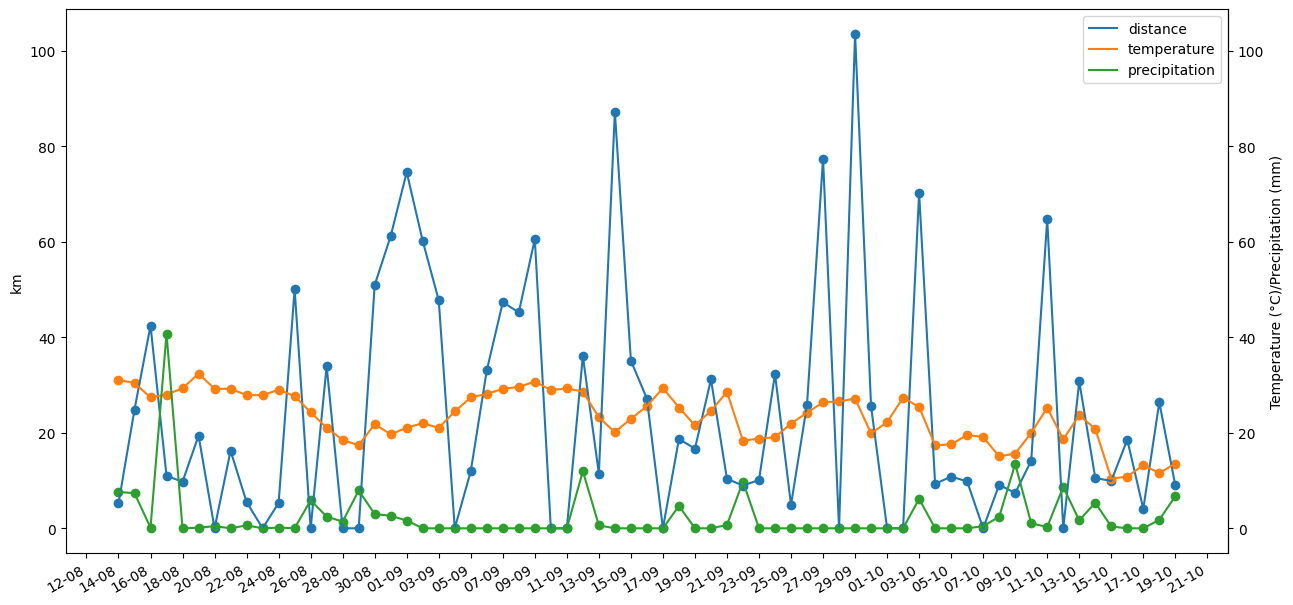

In [9]:
resampled = only_rides.resample("1D", on="start_date_local").sum()
resampled = resampled["distance"] / 1000
resampled = resampled.fillna(0)
drawstyle = "default"
fig, ax = plt.subplots(figsize=(15, 8))
ax_km, = ax.plot(resampled.index, resampled, drawstyle=drawstyle)
ax.scatter(resampled.index, resampled)
ax_temperature, = ax.plot(dw_df.date, dw_df["temperature.max"], drawstyle=drawstyle)
ax.scatter(dw_df.date, dw_df["temperature.max"])
ax_precipitation, = ax.plot(dw_df.date, dw_df["precipitation.total"], drawstyle=drawstyle)
ax.scatter(dw_df.date, dw_df["precipitation.total"])
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
secax = ax.secondary_yaxis("right")
secax.set_ylabel('Temperature (°C)/Precipitation (mm)')
plt.gcf().autofmt_xdate()
plt.ylabel("km")
plt.legend([ax_km, ax_temperature, ax_precipitation], ["distance", "temperature", "precipitation"])
plt.show()

In [10]:
joined_df = pd.concat([resampled.copy(deep=True), dw_df.set_index("date")[["temperature.max", "precipitation.total", "wind.max.speed"]]], axis=1, join="inner")
joined_df

,distance,temperature.max,precipitation.total,wind.max.speed
2023-08-14,5.2013,31.07,7.62,6.69
2023-08-15,24.8621,30.42,7.35,5.14
2023-08-16,42.4250,27.39,0.13,3.13
2023-08-17,10.9776,28.01,40.76,7.20
2023-08-18,9.7525,29.31,0.00,5.14
...,...,...,...,...
2023-10-15,9.9090,10.42,0.38,8.23
2023-10-16,18.5494,10.81,0.00,6.69
2023-10-17,4.0756,13.24,0.00,4.12
2023-10-18,26.3968,11.56,1.78,7.72


In [11]:
joined_df.corr()

,distance,temperature.max,precipitation.total,wind.max.speed
distance,1.000000,0.115818,-0.118671,0.067644
temperature.max,0.115818,1.000000,0.002227,-0.201036
precipitation.total,-0.118671,0.002227,1.000000,0.199800
wind.max.speed,0.067644,-0.201036,0.199800,1.000000
